# Running the Whole Longitudinal ARIA-E Analysis Pipeline

In [2]:
import numpy as np
import os
import pandas as pd
import shutil
import nipype.interfaces.fsl as fsl
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
from intensity_normalization.typing import Modality
from intensity_normalization.normalize.nyul import NyulNormalize
from intensity_normalization.plot.histogram import HistogramPlotter

# import my own helper modules
import Registration as rg 
import Process3DFLAIR as p3df
import ZscoreClustering as zc

### Run the preprocessing pipeline and generate the Z score maps for the subject's variance

In [15]:
# open the subject info table and turn into pd dataframe
subject_info_df = pd.read_csv('/home/ela/Documents/longitudinal_ARIA_E_detection/subject_info.csv')
print(subject_info_df) # print current subject info

# select the subject/s to be processed (set this just to loop through all if that's what we want)
sp = [0]

for i in range(0, len(sp)):
    # select patient ID and number of time points in the sequences
    test_subject_id = subject_info_df.Subject_ID[sp[i]]
    test_total_num_time_points = subject_info_df.Time_Points[sp[i]]

    # select the time points we want to consider in analysis
    test_time_points_to_consider = list(range(1, test_total_num_time_points + 1))

    # define the type of registration we'd like to use
    registration_method = 'affinefsl'

    # we don't want to normalise across all patients
    inter_subject = False

    #  initialise a preprocess pipeline based on the test subject
    testProcess3DFLAIR = p3df.Process3DFLAIR(subject_info_df, test_subject_id, test_total_num_time_points, test_time_points_to_consider, registration_method, inter_subject) 

    # compute the Z-score map for the variance
    z_score_in_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/variance_maps/{test_subject_id}_var.nii.gz" # variance
    z_score_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/z_score_map.nii.gz" # variance 
    log_map = True # we need to take the log of the variance maps to make it more 'normal'
    testProcess3DFLAIR.calcZScoreMap(z_score_in_file, z_score_out_file, log_map)


   Subject_ID  Time_Points
0  B-RAP_0027            6
1  B-RAP_0100            5
2  B-RAP_0147            4
Analysing subject: B-RAP_0027
4.354228936812305
1.0944477287825598
Computed Z-Score map


### Run the clustering on the Z-score map

Processing B-RAP_0027...


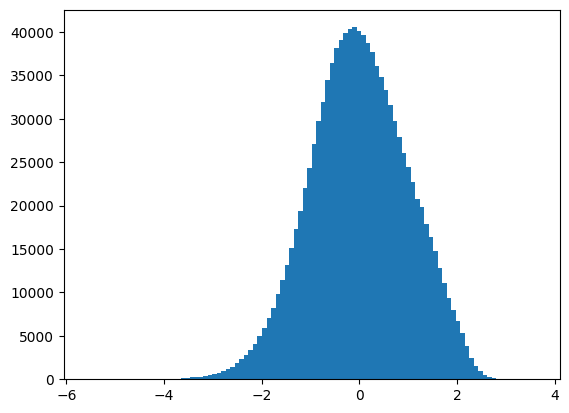

95th Percentile of Z-score Map: 
1.6576203638283937
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


In [16]:
# select the subject/s to be processed (set this just to loop through all if that's what we want)
sp = [0]

for i in range(0, len(sp)):
    # select patient ID and number of time points in the sequences
    test_subject_id = subject_info_df.Subject_ID[sp[i]]
    test_total_num_time_points = subject_info_df.Time_Points[sp[i]]

    print(f"Processing {test_subject_id}...")

    z_score_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/z_score_map.nii.gz" # variance 
    z_score_map = nib.load(z_score_map_file).get_fdata()
    z_score_map_flat = z_score_map.flatten()

    # ignoring, the background, plot the histogram of the z-score map and find the 95th percentile
    brain_mask_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/brain_nifti/masks/{test_subject_id}_0{test_total_num_time_points}_D1.nii"
    brain_mask = nib.load(brain_mask_file)
    brain_mask_flat = brain_mask.get_fdata().flatten()

    # plot the histogram of the z-score map, ignoring the brain_mask
    z_score_map_brain_only = z_score_map_flat[brain_mask_flat > 0]
    plt.hist(z_score_map_brain_only, bins=100)
    plt.show()

    # find the 95th percentile of the z-score map
    z_score_map_95th_percentile = np.percentile(z_score_map_brain_only, 95)

    print('95th Percentile of Z-score Map: ')
    print(z_score_map_95th_percentile)

    # run the clustering pipeline
    testZscoreClustering = zc.ZscoreClustering()
    cluster_info_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/cluster_info.txt"
    cluster_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/raw_clusters.nii.gz"
    threshold = z_score_map_95th_percentile
    testZscoreClustering.clusterZscore(z_score_map_file, cluster_info_out_file, cluster_out_file, threshold)

    # filter clusters so only those above 10 voxels are retained
    thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/thresholded_clusters.nii.gz"
    adjusted_intensity_thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/adjusted_intesity_thresholded_clusters.nii.gz"
    testZscoreClustering.filterClusters(cluster_out_file, cluster_info_out_file, thresholded_cluster_map_file, adjusted_intensity_thresholded_cluster_map_file)

    print("Clusters thresholded at 10 voxels")

### Apply the same protocol to the gradient maps

In [19]:
# open the subject info table and turn into pd dataframe
subject_info_df = pd.read_csv('/home/ela/Documents/longitudinal_ARIA_E_detection/subject_info.csv')
print(subject_info_df) # print current subject info

# select the subject/s to be processed (set this just to loop through all if that's what we want)
sp = [0,1,2] # selected patients


for i in range(0, len(sp)):
    # select patient ID and number of time points in the sequences
    test_subject_id = subject_info_df.Subject_ID[sp[i]]
    test_total_num_time_points = subject_info_df.Time_Points[sp[i]]

    # select the time points we want to consider in analysis
    test_time_points_to_consider = list(range(1, test_total_num_time_points + 1))

    # define the type of registration we'd like to use
    registration_method = 'affinefsl'

    # we don't want to normalise across all patients
    inter_subject = False

    #  initialise a preprocess pipeline based on the test subject
    testProcess3DFLAIR = p3df.Process3DFLAIR(subject_info_df, test_subject_id, test_total_num_time_points, test_time_points_to_consider, registration_method, inter_subject) 

    # compute the Z-score map for the gradient maps
    gradient_map_folder = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/gradient_maps/"

    # iterate through the gradient maps in the folder and compute the z-score maps
    # count the number of gradient maps in the folder
    num_gradient_maps = len([name for name in os.listdir(gradient_map_folder) if os.path.isfile(os.path.join(gradient_map_folder, name))])
    for i in range(1, num_gradient_maps + 1):
        print(f"Processing gradient map {i}...")
        z_score_in_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/gradient_maps/{test_subject_id}_map_{i}.nii.gz"
        z_score_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/z_score_map_{i}.nii.gz"
        log_map = False
        testProcess3DFLAIR.calcZScoreMap(z_score_in_file, z_score_out_file, log_map)
        print("Processed gradient map.")

   Subject_ID  Time_Points
0  B-RAP_0027            6
1  B-RAP_0100            5
2  B-RAP_0147            4
Analysing subject: B-RAP_0027
Processing gradient map 1...
-0.0005437470496645643
0.06634790513990083
Computed Z-Score map
Processed gradient map.
Processing gradient map 2...
-0.0004947915998483322
0.03758104056582928
Computed Z-Score map
Processed gradient map.
Processing gradient map 3...
1.846351119692727e-05
0.06753282954324508
Computed Z-Score map
Processed gradient map.
Processing gradient map 4...
0.0006624030532196741
0.12323174122080396
Computed Z-Score map
Processed gradient map.
Processing gradient map 5...
-0.001131058674172181
0.3720248842091811
Computed Z-Score map
Processed gradient map.
Analysing subject: B-RAP_0100
Processing gradient map 1...
-0.0004545061302839689
0.34350349072075564
Computed Z-Score map
Processed gradient map.
Processing gradient map 2...
-0.00036097133072011874
0.1823642133637326
Computed Z-Score map
Processed gradient map.
Processing gradie

FileNotFoundError: No such file or no access: '/home/ela/Documents/B-RAPIDD/B-RAP_0147/3D-FLAIR/gradient_maps/B-RAP_0147_map_4.nii.gz'

### Run the clustering on the gradient maps

Processing B-RAP_0027...


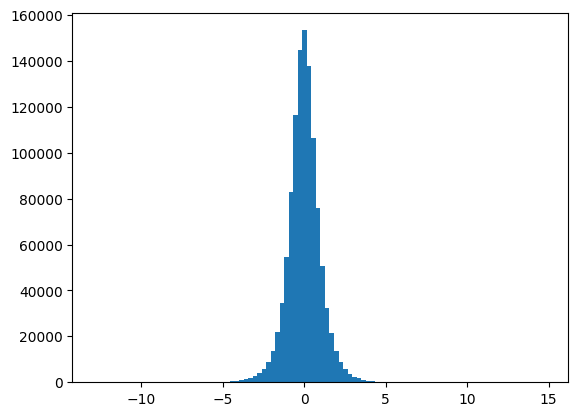

95th Percentile of Z-score Map: 
1.5976853371055937
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


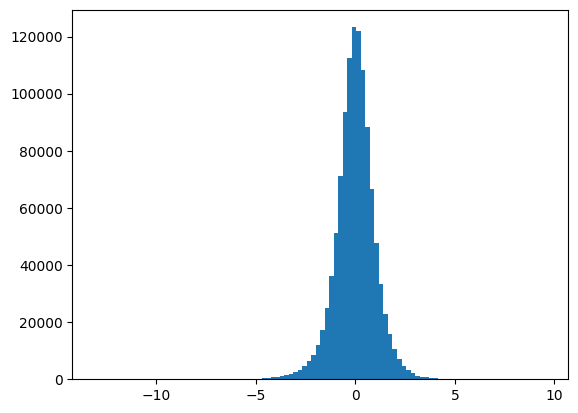

95th Percentile of Z-score Map: 
1.5536798199732498
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


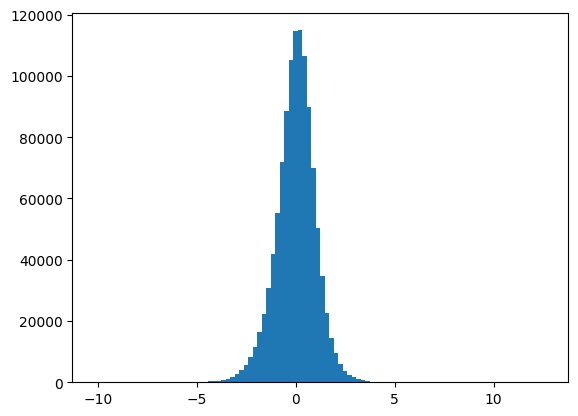

95th Percentile of Z-score Map: 
1.5341786472097523
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


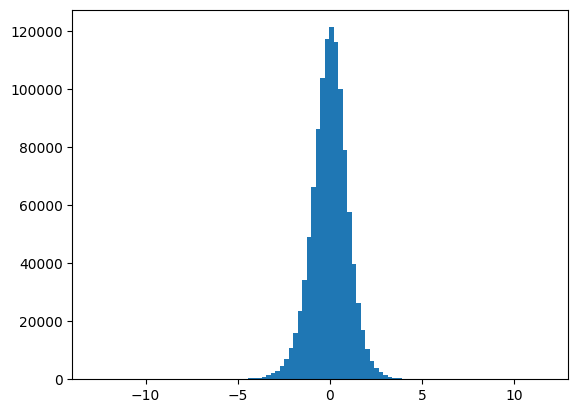

95th Percentile of Z-score Map: 
1.5606953147683984
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


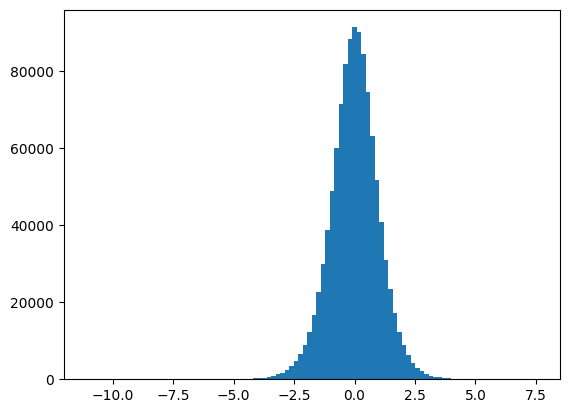

95th Percentile of Z-score Map: 
1.6047286726659857
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels
Processing B-RAP_0100...


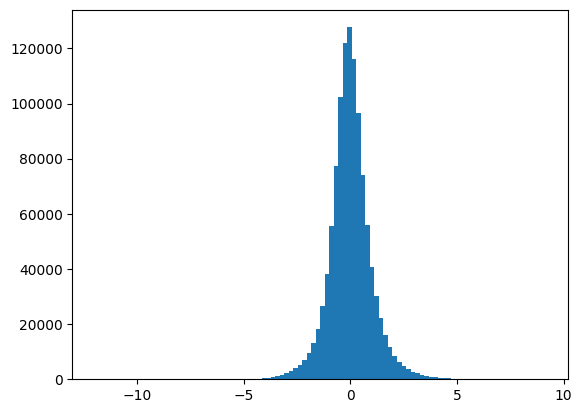

95th Percentile of Z-score Map: 
1.632157886644833
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


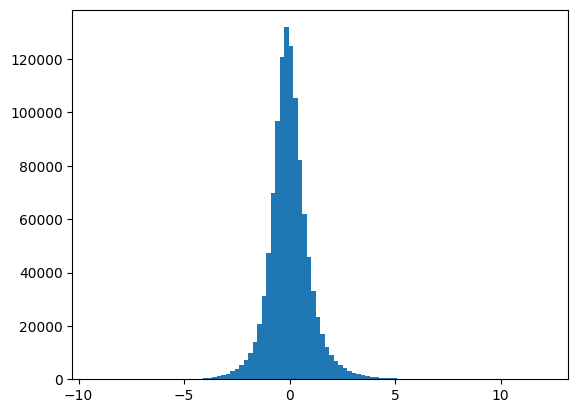

95th Percentile of Z-score Map: 
1.6318557951278243
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


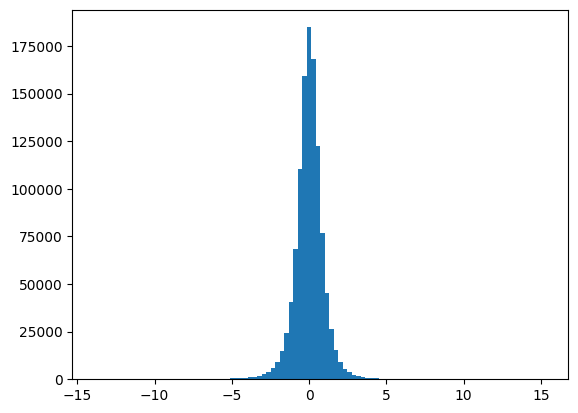

95th Percentile of Z-score Map: 
1.434221583992665
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


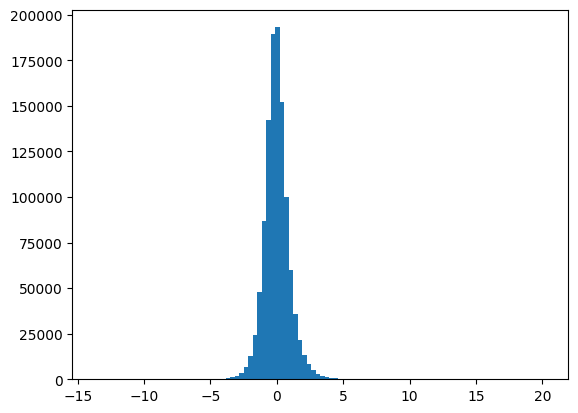

95th Percentile of Z-score Map: 
1.5975469285432873
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels
Processing B-RAP_0147...


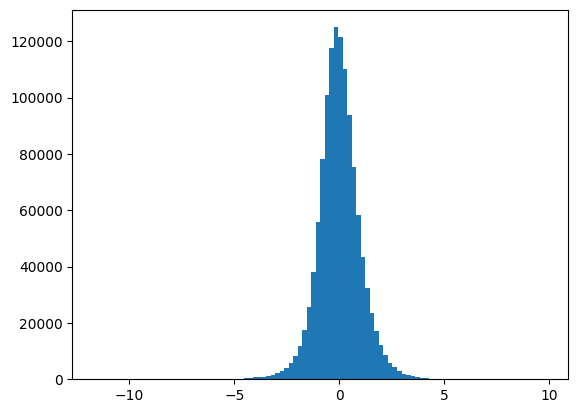

95th Percentile of Z-score Map: 
1.6464026000284187
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


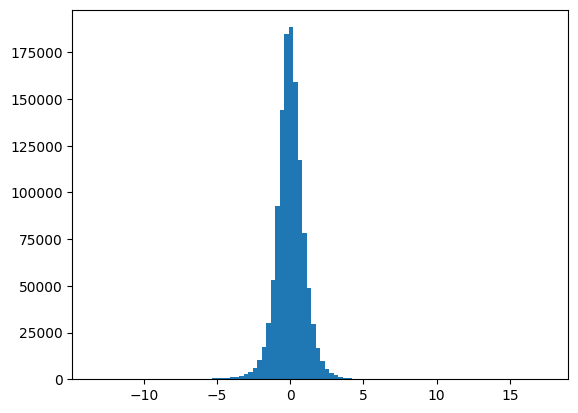

95th Percentile of Z-score Map: 
1.5327883634093182
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


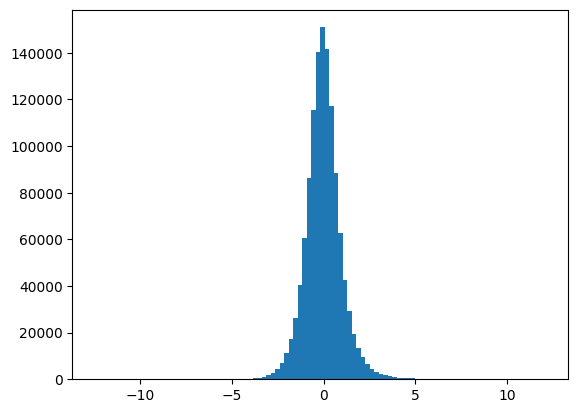

95th Percentile of Z-score Map: 
1.6089807984681939
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


In [24]:
for i in range(0, len(sp)):
    # select patient ID and number of time points in the sequences
    test_subject_id = subject_info_df.Subject_ID[sp[i]]
    test_total_num_time_points = subject_info_df.Time_Points[sp[i]]

    print(f"Processing {test_subject_id}...")

    z_score_map_folder = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/" # variance 

    # create a temp folder because we will need to separate the clustering of positive and negative values 
    temp_folder = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/"

    # create the temp folder if it doesn't exist
    if not os.path.exists(temp_folder):
        os.makedirs(temp_folder)

 
    # count the number of gradient maps in the folder
    num_gradient_maps = len([name for name in os.listdir(z_score_map_folder) if os.path.isfile(os.path.join(z_score_map_folder, name))])

    for i in range(0, num_gradient_maps):
        z_score_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/z_score_map_{i+1}.nii.gz"
        z_score_map_raw = nib.load(z_score_map_file)
        z_score_map = z_score_map_raw.get_fdata()
        z_score_map_flat = z_score_map.flatten()

        # ignoring, the background, plot the histogram of the z-score map and find the 95th percentile
        brain_mask_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/brain_nifti/masks/{test_subject_id}_0{test_total_num_time_points}_D1.nii"
        brain_mask = nib.load(brain_mask_file)
        brain_mask_flat = brain_mask.get_fdata().flatten()

        # plot the histogram of the z-score map, ignoring the brain_mask
        z_score_map_brain_only = z_score_map_flat[brain_mask_flat > 0]
        plt.hist(z_score_map_brain_only, bins=100)
        plt.show()

        # find the 95th percentile of the z-score map
        z_score_map_95th_percentile = np.percentile(z_score_map_brain_only, 95)

        print('95th Percentile of Z-score Map: ')
        print(z_score_map_95th_percentile)

        # run the clustering pipeline
        # gradients can be negative, so we need to consider how to get the cluster values for the negative values below the threshold

        # first lets run the normal clustering and save it to a temp file as these are the positve gradient clusters only
        testZscoreClustering = zc.ZscoreClustering()
        cluster_info_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/raw_cluster_info_map_{i+1}.txt"
        cluster_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/raw_clusters_map_{i+1}.nii.gz"
        threshold = z_score_map_95th_percentile
        testZscoreClustering.clusterZscore(z_score_map_file, cluster_info_out_file, cluster_out_file, threshold)

        # filter clusters so only those above 10 voxels are retained
        thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/thresholded_clusters_map_{i+1}.nii.gz"
        adjusted_intensity_thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/adjusted_intesity_thresholded_clusters_map_{i+1}.nii.gz"
        testZscoreClustering.filterClusters(cluster_out_file, cluster_info_out_file, thresholded_cluster_map_file, adjusted_intensity_thresholded_cluster_map_file)
        
        # now we need to get the negative gradient clusters
        # lets first only retain the negative values in the z-score map
        neg_z_scores_only = z_score_map.copy()
        neg_z_scores_only[neg_z_scores_only > 0] = 0
        # invert the values so they are positive
        neg_z_scores_only = np.abs(neg_z_scores_only)

        # save a temp negative z-score map file
        neg_z_scores_only_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/negative_z_score_map_{i}.nii.gz"
        neg_z_scores_only_file_nifti = nib.Nifti1Image(neg_z_scores_only, affine = None)
        neg_z_scores_only_file_nifti.header.set_qform(z_score_map_raw.header.get_qform())
        neg_z_scores_only_file_nifti.header.set_sform(z_score_map_raw.header.get_sform())
        nib.save(neg_z_scores_only_file_nifti, neg_z_scores_only_file)

        # run the clustering pipeline on the negative z-score map
        neg_cluster_info_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/negative_cluster_info_map_{i+1}.txt"
        neg_cluster_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/negative_raw_clusters_map_{i+1}.nii.gz"
        threshold = z_score_map_95th_percentile
        testZscoreClustering.clusterZscore(neg_z_scores_only_file, neg_cluster_info_out_file, neg_cluster_out_file, threshold)

        # filter clusters so only those above 10 voxels are retained
        neg_thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/negative_thresholded_clusters_map_{i+1}.nii.gz"
        neg_adjusted_intensity_thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/temp/negative_adjusted_intesity_thresholded_clusters_map_{i+1}.nii.gz"
        testZscoreClustering.filterClusters(neg_cluster_out_file, neg_cluster_info_out_file, neg_thresholded_cluster_map_file, neg_adjusted_intensity_thresholded_cluster_map_file)

        # now we need to combine the positive and negative clusters (the thresholded ones)
        # first we need to get the positive clusters
        positive_thresholded_clusters = nib.load(adjusted_intensity_thresholded_cluster_map_file).get_fdata()
        negative_thresholded_clusters = nib.load(neg_adjusted_intensity_thresholded_cluster_map_file).get_fdata()

        # add both the positive and negative clusters together
        combined_clusters = positive_thresholded_clusters + negative_thresholded_clusters

        # save the combined clusters to a file
        combined_clusters_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/gradient/clusters/combined_clusters_map_{i+1}.nii.gz"
        combined_clusters_file_nifti = nib.Nifti1Image(combined_clusters, affine = None)
        combined_clusters_file_nifti.header.set_qform(z_score_map_raw.header.get_qform())
        combined_clusters_file_nifti.header.set_sform(z_score_map_raw.header.get_sform())
        nib.save(combined_clusters_file_nifti, combined_clusters_file)

        print("Clusters thresholded at 10 voxels")

### Separate the CSF and tissue clusters